# Mobile Data Challenge 2024 - EPEAK


In [ ]:
from google.colab import drive
from scipy.signal import find_peaks
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Data Frame Construction


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset location and parameters
data_path = '/content/drive/Shared drives/Gestió de Projectes/3. Executing/Data/'
filenames = ['movilidad_provincias_2022.csv', 'movilidad_provincias_2023.csv', 'movilidad_provincias_2024.csv']
sep = ","
encoding = "utf-8"

# Set pandas to show all columns
pd.set_option('display.max_columns', None)

# Load and concatenate all CSV files into one DataFrame
df = pd.concat(
    [pd.read_csv(data_path + filename, sep=sep, encoding=encoding) for filename in filenames],
    ignore_index=True
)

df.head()

Mounted at /content/drive


,viajeros,viajes,provincia_origen,provincia_origen_name,provincia_destino,provincia_destino_name,day
0,18691,18981,2,Albacete,3,Alicante,2022-09-01
1,279,280,2,Albacete,4,Almería,2022-09-01
2,47,47,2,Albacete,6,Badajoz,2022-09-01
3,15,15,2,Albacete,7,"Balears, Illes",2022-09-01
4,73,77,2,Albacete,8,Barcelona,2022-09-01


In [ ]:
# Get all distinct combinations of 'provincia_origen' and 'provincia_origen_name'
distinct_combinations = df[['provincia_origen', 'provincia_origen_name']].drop_duplicates()

# Sort the distinct combinations by 'provincia_origen'
distinct_combinations_sorted = distinct_combinations.sort_values(by='provincia_origen')

# Optionally, reset the index for better readability
distinct_combinations_sorted.reset_index(drop=True, inplace=True)

# Display the sorted distinct combinations
print(distinct_combinations_sorted)

    provincia_origen   provincia_origen_name
0                  1             Araba/Álava
1                  2                Albacete
2                  3                Alicante
3                  4                 Almería
4                  5                   Ávila
5                  6                 Badajoz
6                  7          Balears, Illes
7                  8               Barcelona
8                  9                  Burgos
9                 10                 Cáceres
10                11                   Cádiz
11                12      Castellón/Castelló
12                13             Ciudad Real
13                14                 Córdoba
14                15               Coruña, A
15                16                  Cuenca
16                17                  Girona
17                18                 Granada
18                19             Guadalajara
19                20                Gipuzkoa
20                21                  Huelva
21        

## Exploratory Data Analysis


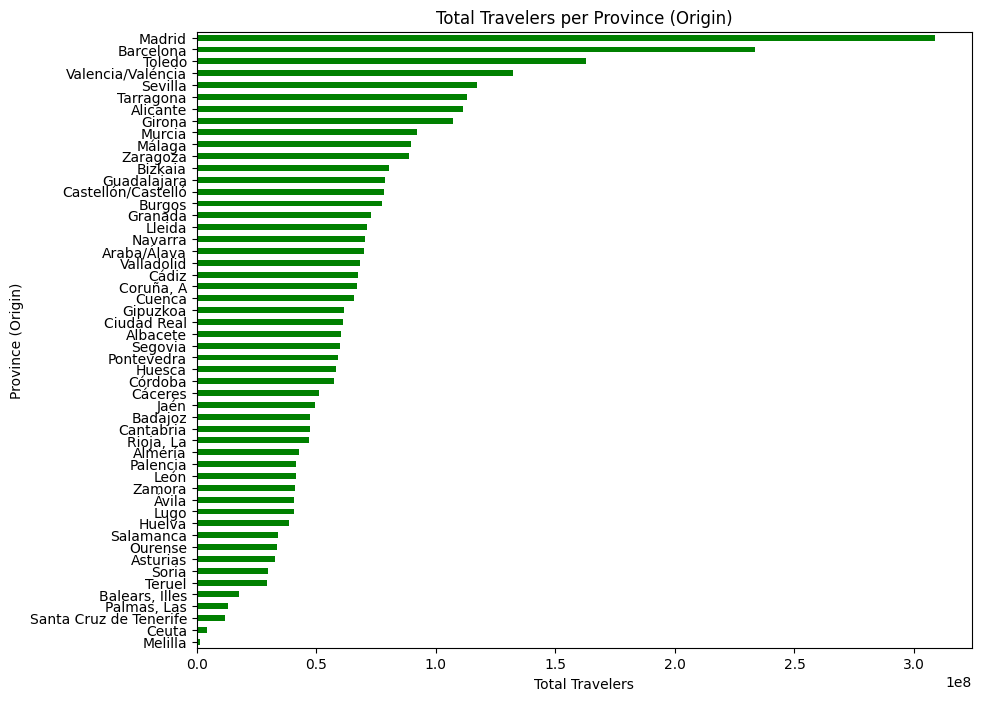

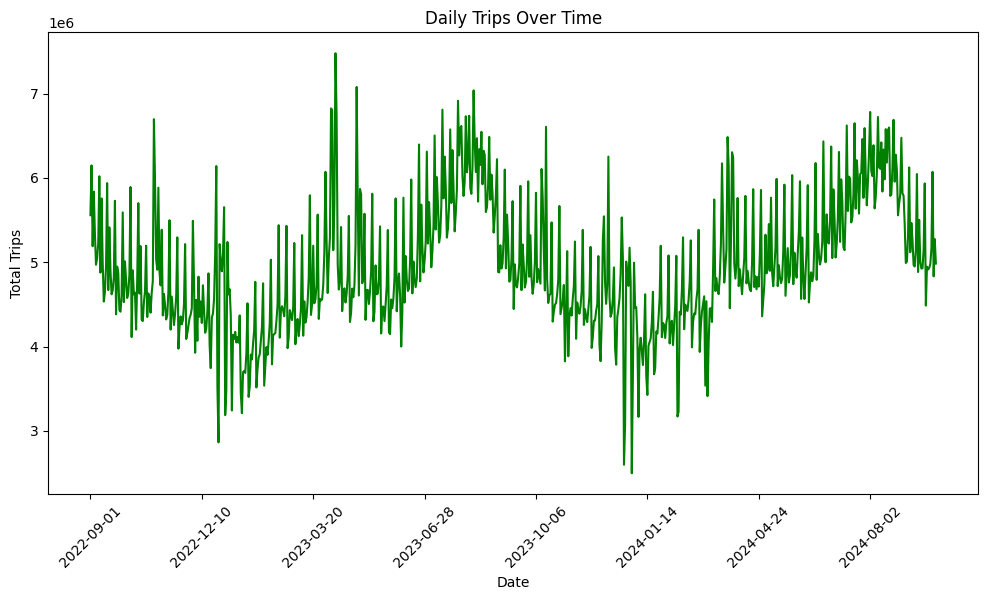

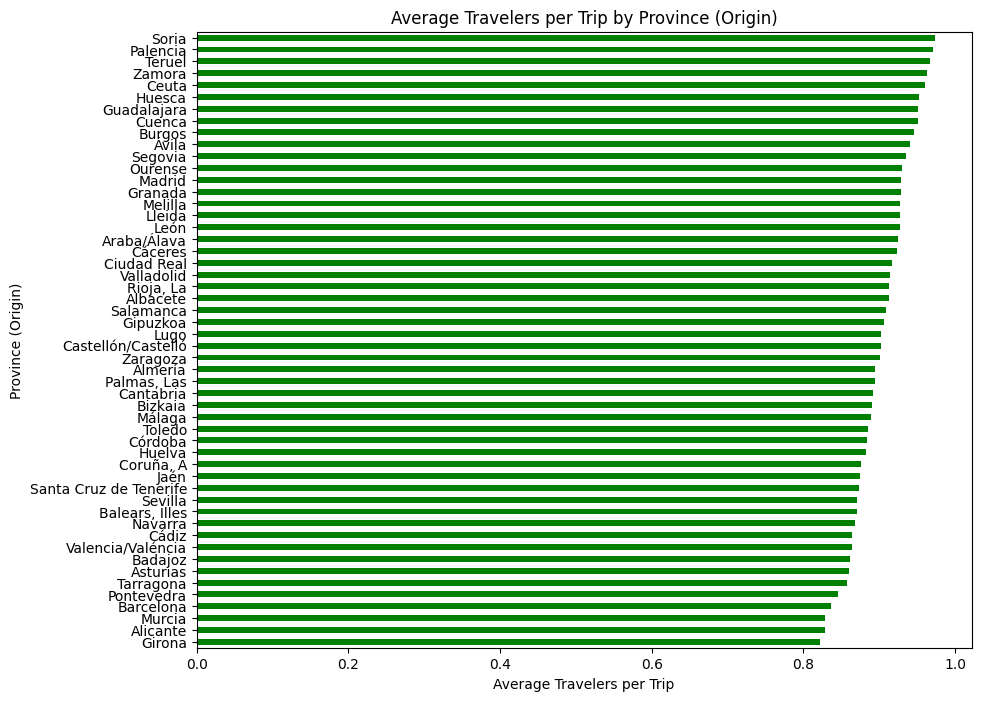

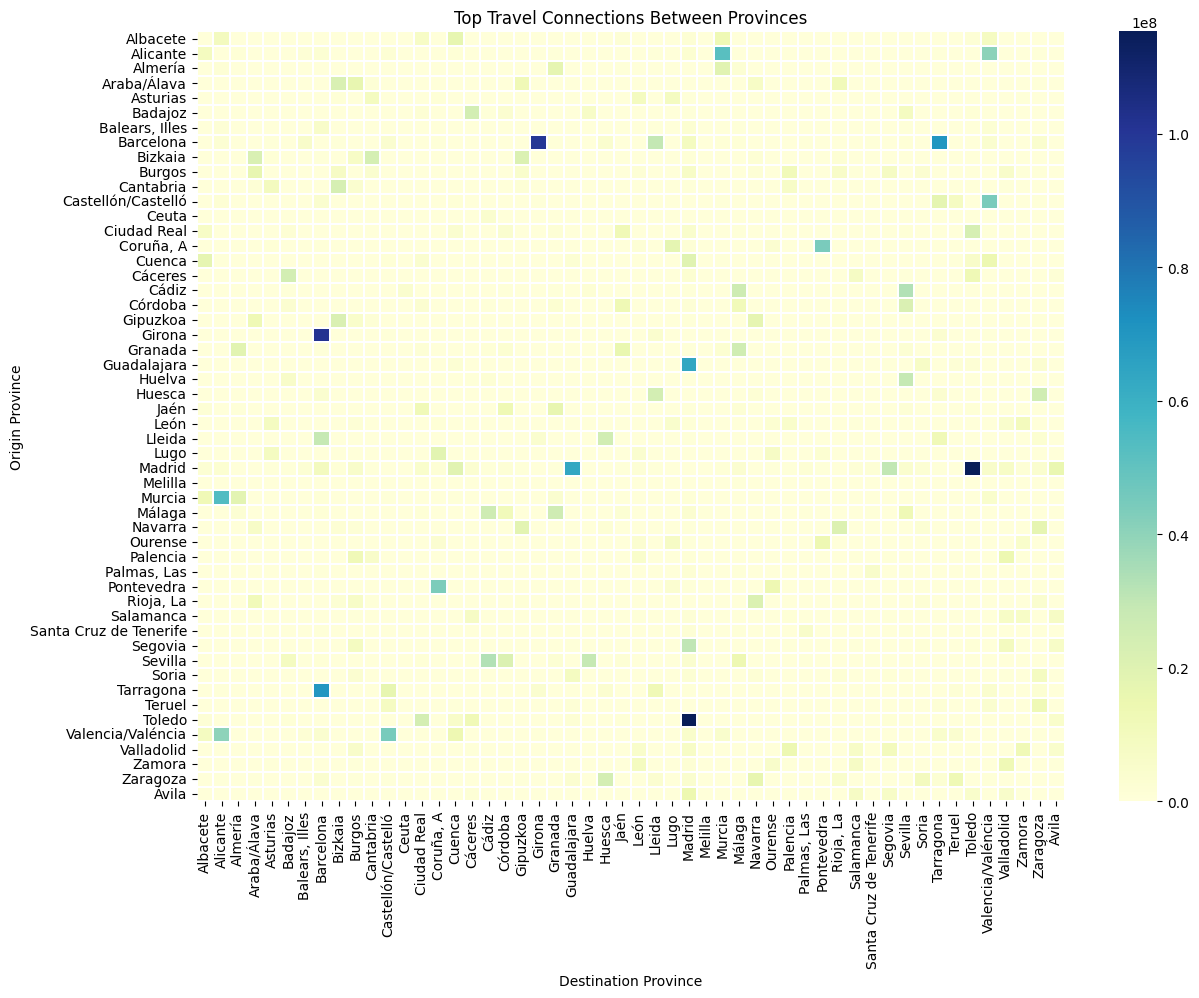

In [ ]:
# 1. Total Travelers per Province (Origin) - Horizontal Bar Plot for better readability
travelers_by_origin = df.groupby('provincia_origen_name')['viajeros'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
travelers_by_origin.plot(kind='barh', color='green')
plt.title('Total Travelers per Province (Origin)')
plt.xlabel('Total Travelers')
plt.ylabel('Province (Origin)')
plt.gca().invert_yaxis()  # To have the highest value at the top
plt.show()

'''# 2. Total Trips per Province (Destination) - Horizontal Bar Plot for better readability
trips_by_destination = df.groupby('provincia_destino_name')['viajes'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
trips_by_destination.plot(kind='barh', color='green')
plt.title('Total Trips per Province (Destination)')
plt.xlabel('Total Trips')
plt.ylabel('Province (Destination)')
plt.gca().invert_yaxis()
plt.show()'''

# 3. Daily Trips Over Time - Check and fix the date format if needed
daily_trips = df.groupby('day')['viajes'].sum()
plt.figure(figsize=(12, 6))
daily_trips.plot(color='green')
plt.title('Daily Trips Over Time')
plt.xlabel('Date')
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.show()

# 4. Average Travelers per Trip by Province
# Filter out rows where 'viajes' is zero to avoid division errors
df_non_zero_trips = df[df['viajes'] > 0].copy()
df_non_zero_trips['travelers_per_trip'] = df_non_zero_trips['viajeros'] / df_non_zero_trips['viajes']

avg_travelers_by_province = df_non_zero_trips.groupby('provincia_origen_name')['travelers_per_trip'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
avg_travelers_by_province.plot(kind='barh', color='green')
plt.title('Average Travelers per Trip by Province (Origin)')
plt.xlabel('Average Travelers per Trip')
plt.ylabel('Province (Origin)')
plt.gca().invert_yaxis()
plt.show()

# 5. Top Travel Connections Between Provinces (Heatmap)
top_connections = df.groupby(['provincia_origen_name', 'provincia_destino_name'])['viajes'].sum().unstack().fillna(0)
plt.figure(figsize=(14, 10))
sns.heatmap(top_connections, cmap="YlGnBu", linewidths=0.1)
plt.title('Top Travel Connections Between Provinces')
plt.xlabel('Destination Province')
plt.ylabel('Origin Province')
plt.show()

### Average peak detection (without taking provinces into account)

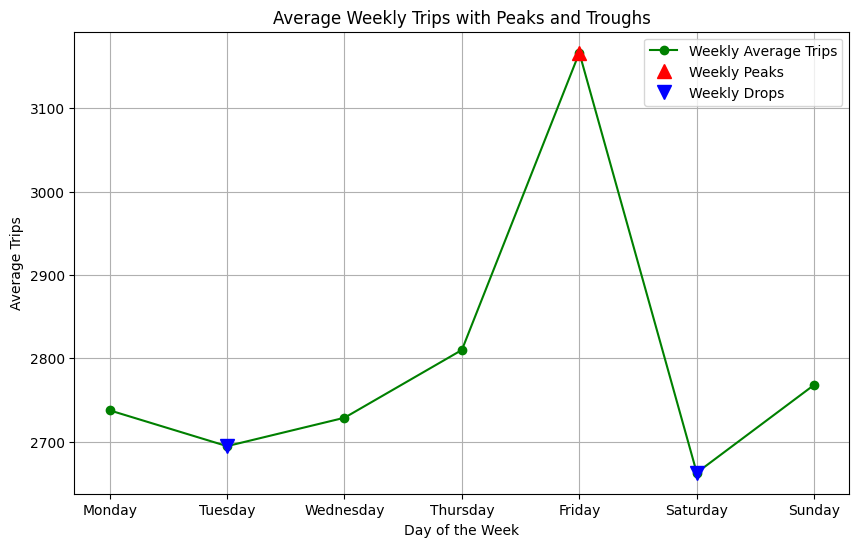

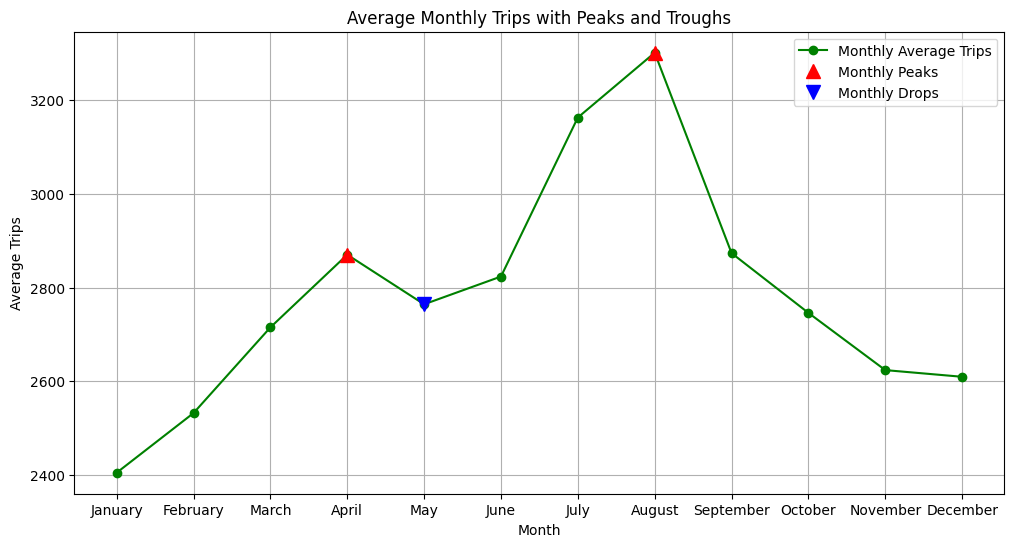

In [ ]:
# Convert 'day' column to datetime if not already in datetime format
df['day'] = pd.to_datetime(df['day'])

# Aggregate by day of the week to see weekly patterns
df['day_of_week'] = df['day'].dt.day_name()
weekly_trips = df.groupby('day_of_week')['viajes'].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Aggregate by month to see seasonal trends
df['month'] = df['day'].dt.month_name()
monthly_trips = df.groupby('month')['viajes'].mean().reindex(
    ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
)

# Plotting weekly data with peaks and troughs
plt.figure(figsize=(10, 6))
plt.plot(weekly_trips.index, weekly_trips.values, color='green', marker='o', label='Weekly Average Trips')
weekly_peaks, _ = find_peaks(weekly_trips.values, prominence=0.1)  # Adjust prominence as needed
weekly_troughs, _ = find_peaks(-weekly_trips.values, prominence=0.1)
plt.plot(weekly_trips.index[weekly_peaks], weekly_trips.values[weekly_peaks], 'r^', markersize=10, label='Weekly Peaks')  # Increased size
plt.plot(weekly_trips.index[weekly_troughs], weekly_trips.values[weekly_troughs], 'bv', markersize=10, label='Weekly Drops')  # Increased size
plt.title('Average Weekly Trips with Peaks and Troughs')
plt.xlabel('Day of the Week')
plt.ylabel('Average Trips')
plt.legend()
plt.grid(True)
plt.show()

# Plotting monthly data with peaks and troughs
plt.figure(figsize=(12, 6))
plt.plot(monthly_trips.index, monthly_trips.values, color='green', marker='o', label='Monthly Average Trips')
monthly_peaks, _ = find_peaks(monthly_trips.values, prominence=0.1)
monthly_troughs, _ = find_peaks(-monthly_trips.values, prominence=0.1)
plt.plot(monthly_trips.index[monthly_peaks], monthly_trips.values[monthly_peaks], 'r^', markersize=10, label='Monthly Peaks')  # Increased size
plt.plot(monthly_trips.index[monthly_troughs], monthly_trips.values[monthly_troughs], 'bv', markersize=10, label='Monthly Drops')  # Increased size
plt.title('Average Monthly Trips with Peaks and Troughs')
plt.xlabel('Month')
plt.ylabel('Average Trips')
plt.legend()
plt.grid(True)
plt.show()

## Forecasting

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lcla93d/zk3vqtpd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lcla93d/ivdur1oe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82206', 'data', 'file=/tmp/tmp1lcla93d/zk3vqtpd.json', 'init=/tmp/tmp1lcla93d/ivdur1oe.json', 'output', 'file=/tmp/tmp1lcla93d/prophet_model58si7f0i/prophet_model-20241103120620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


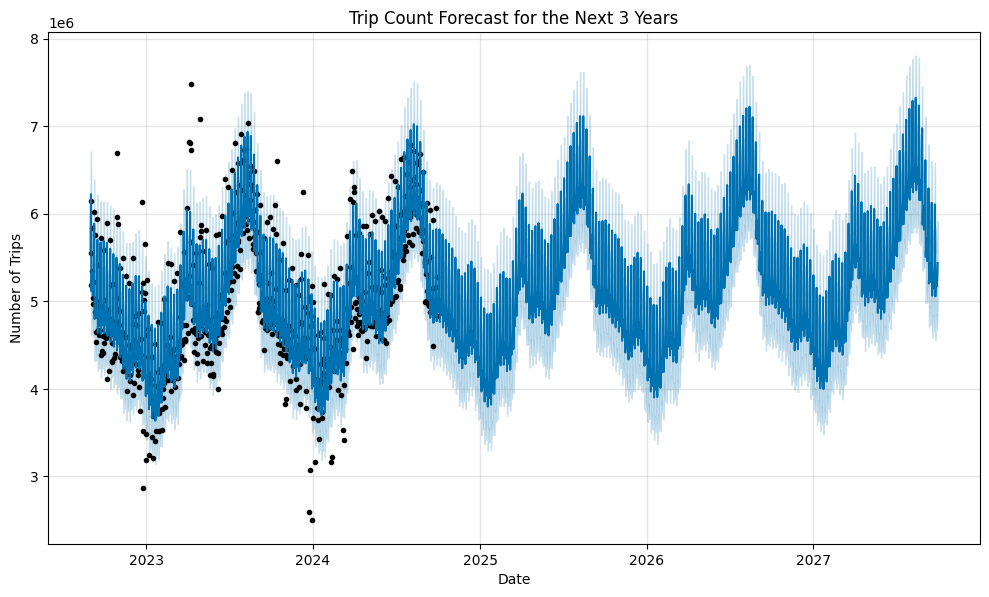

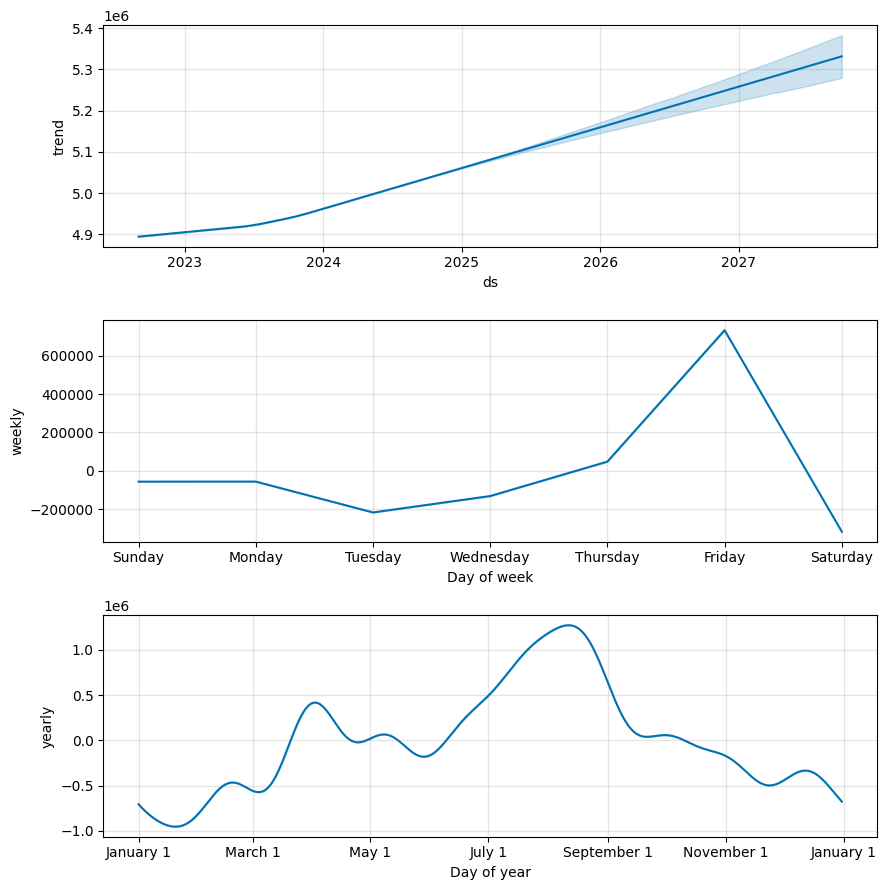

In [ ]:
# Convert 'day' column to datetime if not already in datetime format
df['day'] = pd.to_datetime(df['day'])

# Aggregate trip data by day
daily_trips = df.groupby('day')['viajes'].sum().reset_index()  # Change 'viajes' as necessary for your metric
daily_trips.columns = ['ds', 'y']  # Rename columns for Prophet

# Initialize and fit the Prophet model
model = Prophet()
model.fit(daily_trips)

# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=365 * 3)  # Forecast for 3 years into the future

# Make predictions
forecast = model.predict(future)

# Plot the results
fig = model.plot(forecast)
plt.title('Trip Count Forecast for the Next 3 Years')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

# Optionally, plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lcla93d/vl2y1z1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lcla93d/f5ajpill.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76592', 'data', 'file=/tmp/tmp1lcla93d/vl2y1z1b.json', 'init=/tmp/tmp1lcla93d/f5ajpill.json', 'output', 'file=/tmp/tmp1lcla93d/prophet_model_o7tc4_h/prophet_model-20241103120623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lcla93d/5_bjf2fu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1lcla93d/lgybimfu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  provincia_origen_name          yhat
3                Madrid  4.952896e+08
1             Barcelona  3.782195e+08
8                Toledo  2.566479e+08
9     Valencia/Valéncia  2.124708e+08
0              Alicante  1.806868e+08
6               Sevilla  1.798107e+08
7             Tarragona  1.772873e+08
2                Girona  1.732136e+08
4                Murcia  1.557761e+08
5                Málaga  1.490283e+08


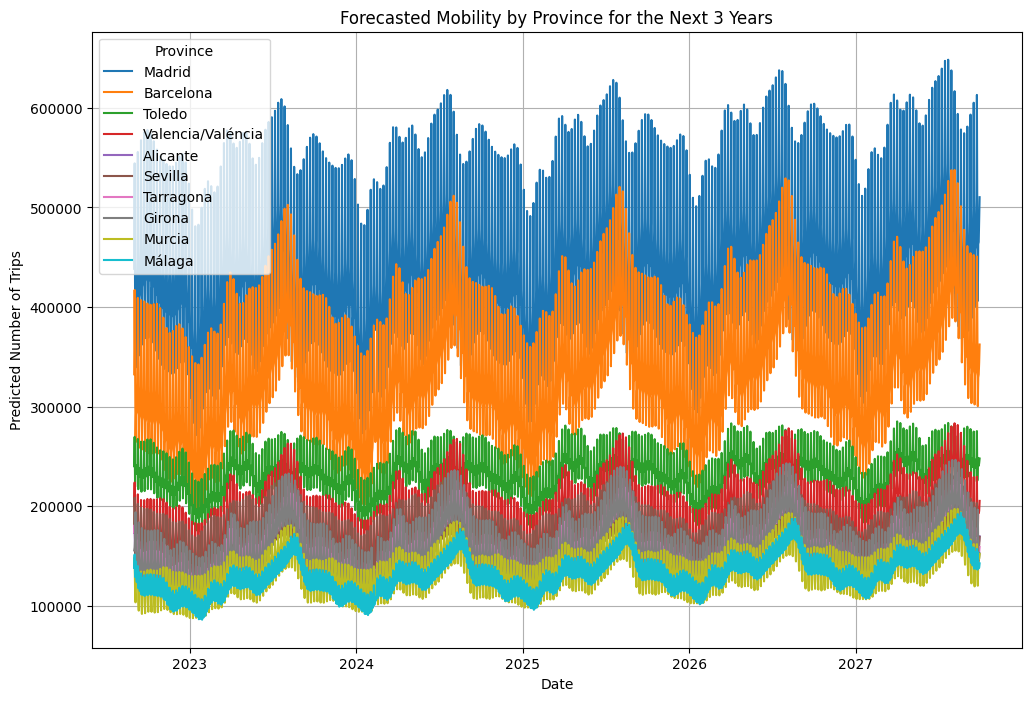

In [ ]:
# Convert 'day' column to datetime if not already in datetime format
df['day'] = pd.to_datetime(df['day'])

# Aggregate trip data by day and province
daily_trips = df.groupby(['day', 'provincia_origen_name'])['viajes'].sum().reset_index()

# Identify the top 10 provinces based on trip counts
top_provinces = daily_trips.groupby('provincia_origen_name')['viajes'].sum().nlargest(10).index

# Filter the DataFrame for only the top 10 provinces
daily_trips_top = daily_trips[daily_trips['provincia_origen_name'].isin(top_provinces)]

# List to hold forecasts for all provinces
forecasts = []

# Fit Prophet model for each province and forecast
for province in daily_trips_top['provincia_origen_name'].unique():
    province_data = daily_trips_top[daily_trips_top['provincia_origen_name'] == province].copy()

    # Ensure we only keep the necessary columns
    province_data = province_data[['day', 'viajes']]  # Keep only relevant columns
    province_data.columns = ['ds', 'y']  # Rename columns for Prophet

    # Initialize and fit the Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(province_data)

    # Create future dates for forecasting
    future = model.make_future_dataframe(periods=365 * 3)  # Forecast for 3 years into the future
    forecast = model.predict(future)

    # Add province name to forecast
    forecast['provincia_origen_name'] = province
    forecasts.append(forecast)

# Combine all forecasts into a single DataFrame
all_forecasts = pd.concat(forecasts)

# Group forecasts by province and aggregate future trip counts
mobility_forecast = all_forecasts.groupby('provincia_origen_name').tail(365 * 3)  # Get the last 3 years of forecasts
mobility_summary = mobility_forecast.groupby('provincia_origen_name')['yhat'].sum().reset_index()

# Sort by predicted mobility (highest to lowest)
mobility_summary = mobility_summary.sort_values(by='yhat', ascending=False)

# Display the top provinces with predicted mobility
print(mobility_summary)

# Visualize the results
plt.figure(figsize=(12, 8))
for province in mobility_summary['provincia_origen_name']:
    province_forecast = all_forecasts[all_forecasts['provincia_origen_name'] == province]
    plt.plot(province_forecast['ds'], province_forecast['yhat'], label=province)

plt.title('Forecasted Mobility by Province for the Next 3 Years')
plt.xlabel('Date')
plt.ylabel('Predicted Number of Trips')
plt.legend(title='Province')
plt.grid(True)
plt.show()